In [348]:
import networkx as nx
import re
import json
import random
import matplotlib.pyplot as plt

def read_graph_from_gml(file_path):
    G = nx.Graph()
    with open(file_path, 'r') as file:
        current_node = None
        reading_edges = False  # Indique si nous lisons les arêtes du graphe
        reading_node = False  # Indique si nous lisons les noeuds du graphe
        source = None  
        target = None  
        width = None  
        for line in file:
            line = line.strip()
            if line.startswith('node'):  # Si la ligne indique un noeud
                reading_node = True  # Nous commençons à lire les noeuds
                current_node = {}  # Initialisation du dictionnaire de noeud actuel
            elif line.startswith('edge'):  # Si la ligne indique une arête
                reading_edges = True  # Nous commençons à lire les arêtes
            elif line.startswith(']'):  # Si nous arrivons à la fin de la définition d'un noeud ou d'une arête
                reading_node = False  # Nous avons fini de lire les noeuds
                reading_edges = False  # Nous avons fini de lire les arêtes
                if source is not None and target is not None and width is not None:
                    # Si nous avons des informations complètes sur une arête
                    G.add_edge(source, target, weight=width)  # Ajout de l'arête avec son poids au graphe
                    source = None  
                    target = None 
                    width = None  
            elif line.startswith('id'):  # Si la ligne indique l'ID d'un noeud
                current_node['id'] = int(re.search(r'\d+', line).group())  # Récupération de l'ID
                G.add_node(current_node['id'])  # Ajout du noeud avec son ID au graphe
            elif reading_edges:  # Si nous lisons les arêtes
                if line.startswith('source'):  # Si la ligne indique la source de l'arête
                    source = int(re.search(r'\d+', line).group())  
                elif line.startswith('target'):  # Si la ligne indique la cible de l'arête
                    target = int(re.search(r'\d+', line).group())  
                elif line.startswith('width') or line.startswith('weight'):  # Si la ligne indique la largeur ou le poids de l'arête
                    width = float(re.search(r'\d+\.\d+', line).group())  
    return G


def calculate_modularity(G, partition):
    modularity = 0  # Initialise la modularité à 0
    m = sum(weight for _, _, weight in G.edges.data('weight', default=1))  # Calcul de la somme des poids des arêtes
    if m == 0: return 0  # Si la somme des poids est nulle, retourne 0 (évite la division par zéro)
    for community in set(partition.values()):  # Parcourt toutes les communautés dans le partitionnement
        nodes_in_community = [node for node, comm in partition.items() if comm == community]  # Obtient tous les nœuds dans la communauté actuelle
        for node_i in nodes_in_community:  # Parcourt tous les nœuds dans la communauté actuelle
            for node_j in nodes_in_community:  # Parcourt à nouveau tous les nœuds dans la communauté actuelle
                if G.has_edge(node_i, node_j):  # Vérifie s'il y a une arête entre les nœuds
                    A_ij = G[node_i][node_j]['weight'] if 'weight' in G[node_i][node_j] else 1  # Si oui, obtient le poids de l'arête
                else:
                    A_ij = 0  # Sinon, initialise le poids de l'arête à 0
                ki = 0  # Initialise le degré du nœud i à 0
                for neighbor in G.neighbors(node_i):  # Parcourt tous les voisins du nœud i
                    if 'weight' in G[node_i][neighbor]:  # Vérifie s'il y a une arête pondérée
                        ki += G[node_i][neighbor]['weight']  # Ajoute le poids de l'arête au degré du nœud i
                        
                kj = 0  # Initialise le degré du nœud j à 0
                for neighbor in G.neighbors(node_j):  # Parcourt tous les voisins du nœud j
                    if 'weight' in G[node_j][neighbor]:  # Vérifie s'il y a une arête pondérée
                        kj += G[node_j][neighbor]['weight']  # Ajoute le poids de l'arête au degré du nœud j
                modularity += (A_ij - (ki * kj) / (2 * m))  # Calcule la contribution à la modularité
    modularity /= (2 * m)  
    return modularity  


def create_partition_graph(G, partition):
    partition_graph = nx.Graph()  # Crée un graphe pour la partition
    for node, community in partition.items():
        partition_graph.add_node(community)  # Ajoute la communauté comme nœud dans le graphe
    for node_i, node_j in G.edges():
        if partition[node_i] != partition[node_j]:  # Si le lien entre les nœuds est entre des communautés différentes
            total_weight = G[node_i][node_j].get('weight', 0)  # Poids total de l'arête
            if partition_graph.has_edge(partition[node_i], partition[node_j]):  # Si le graphe de partition a déjà une arête entre les communautés
                # Ajoute le poids total à la pondération de l'arête existante
                partition_graph[partition[node_i]][partition[node_j]]['weight'] += total_weight
            else:
                # Sinon, ajoute une nouvelle arête avec le poids total
                partition_graph.add_edge(partition[node_i], partition[node_j], weight=total_weight)
    return partition_graph  # Retourne le graphe de partition mis à jour



def get_node_partition(original_partition, new_partition):
    node_partition = {}  # Crée une partition des nœuds en fonction de la nouvelle partition des communautés
    for node, community in original_partition.items():
        node_partition[node] = new_partition[community]  # Détermine dans quelle nouvelle communauté le nœud appartient
    return node_partition  # Retourne la partition des nœuds mise à jour


def find_best_community(G, node, partition):
    best_community = partition[node]  # Initialise la meilleure communauté à celle à laquelle appartient initialement le nœud
    best_modularity = calculate_modularity(G, partition)  # Calcule la modularité actuelle du partitionnement
    neighbors = list(G.neighbors(node))  # Récupère les voisins du nœud
    random.shuffle(neighbors)  # Mélange aléatoirement les voisins
    for neighbor in neighbors:  # Parcourt chaque voisin
        current_partition = partition.copy()  # Crée une copie du partitionnement actuel
        current_partition[node] = current_partition[neighbor]  # Change temporairement la communauté du nœud à celle de son voisin
        current_partition_modularity = calculate_modularity(G, current_partition)  # Calcule la modularité du partitionnement modifié
        if current_partition_modularity > best_modularity:  # Vérifie si la nouvelle modularité est meilleure que la meilleure modularité actuelle
            best_modularity = current_partition_modularity  # Met à jour la meilleure modularité
            best_community = current_partition[node]  # Met à jour la meilleure communauté
    return best_community  # Retourne la meilleure communauté trouvée


def louvain(G):
    partition = {node: node for node in G.nodes()}  # Initialise chaque nœud dans sa propre communauté
    improved = True  # Indique si une amélioration du partitionnement est encore possible
    
    improved = False  # Initialise à False avant de parcourir tous les nœuds
    nodes = list(G.nodes())  # Liste tous les nœuds du graphe
    random.shuffle(nodes)  # Mélange aléatoirement l'ordre des nœuds
    for node in nodes:  # Parcourt chaque nœud dans un ordre aléatoire
        current_community = partition[node]  # Identifie la communauté actuelle du nœud
        best_community = find_best_community(G, node, partition)  # Trouve la meilleure communauté pour le nœud
        if best_community != current_community:  # Vérifie s'il y a une amélioration possible
            partition[node] = best_community  # Met à jour la communauté du nœud
            improved = True  # Indique qu'une amélioration a été effectuée
    return partition  # Retourne le partitionnement final optimisé


def louvain_until_convergence(G):
    prev_modularity = float('-inf')  # Initialise la modularité précédente à moins l'infini
    partition = {node: node for node in G.nodes()}  # Initialise le partitionnement initial où chaque nœud est dans sa propre communauté
    hierarchies = []  # Tableau pour stocker les hiérarchies des partitionnements
    hierarchies_partition_final = []  # Tableau pour stocker les partitionnements finaux
    graph = []  # Tableau pour stocker les graphes partitionnés
    c = 0  # Compteur pour suivre le nombre d'itérations
    
    graph.append(G.copy())  # Ajoute une copie du graphe original au tableau des graphes
    partition = louvain(graph[c])  # Applique l'algorithme Louvain au graphe actuel
    prev_modularity = calculate_modularity(G, partition)  # Calcule la modularité du partitionnement actuel
    hierarchies.append(partition)  # Ajoute le partitionnement actuel à la liste des hiérarchies
    hierarchies_partition_final.append(partition)  # Ajoute le partitionnement actuel à la liste des partitionnements finaux
    
    while True:  # Boucle jusqu'à convergence
        graph.append(create_partition_graph(graph[c], partition))  # Crée un nouveau graphe à partir du partitionnement actuel
        c = c + 1  # Incrémente le compteur d'itérations
        new_partition = louvain(graph[c])  # Applique à nouveau l'algorithme Louvain sur le nouveau graphe
        partition = new_partition  # Met à jour le partitionnement
        new_node_partition = new_partition  # Initialise le partitionnement des nœuds
        
        for i in range(c):  # Parcourt chaque partitionnement précédent
            new_node_partition = get_node_partition(hierarchies[c-i-1], new_node_partition)  # Rétablit le partitionnement des nœuds à partir du partitionnement précédent
        
        modularity = calculate_modularity(G, new_node_partition)  # Calcule la modularité du nouveau partitionnement
        
        if modularity > prev_modularity:  # Vérifie s'il y a amélioration de la modularité
            prev_modularity = modularity  # Met à jour la modularité précédente
            hierarchies.append(new_partition)  # Ajoute le nouveau partitionnement à la liste des hiérarchies
            hierarchies_partition_final.append(new_node_partition)  # Ajoute le partitionnement des nœuds correspondant à la liste des partitionnements finaux
        else:
            break  # Sort de la boucle si aucune amélioration n'est possible
    
    return hierarchies, hierarchies_partition_final, graph, c  # Retourne les hiérarchies des partitionnements, les partitionnements finaux, les graphes partitionnés et le nombre d'itérations effectuées


In [361]:
file_path = 'LR_graph_Macrophages_Tcells.gml' 
#file_path = 'LR_graph_visu-merged.gml' 
#file_path = 'corr_distance_Plasma-cells.gml' 
  
G = read_graph_from_gml(file_path)
#G = nx.karate_club_graph()


p, f, gr, num = louvain_until_convergence(G)

In [362]:
print(calculate_modularity(G, f[1]))



0.7734452683450589


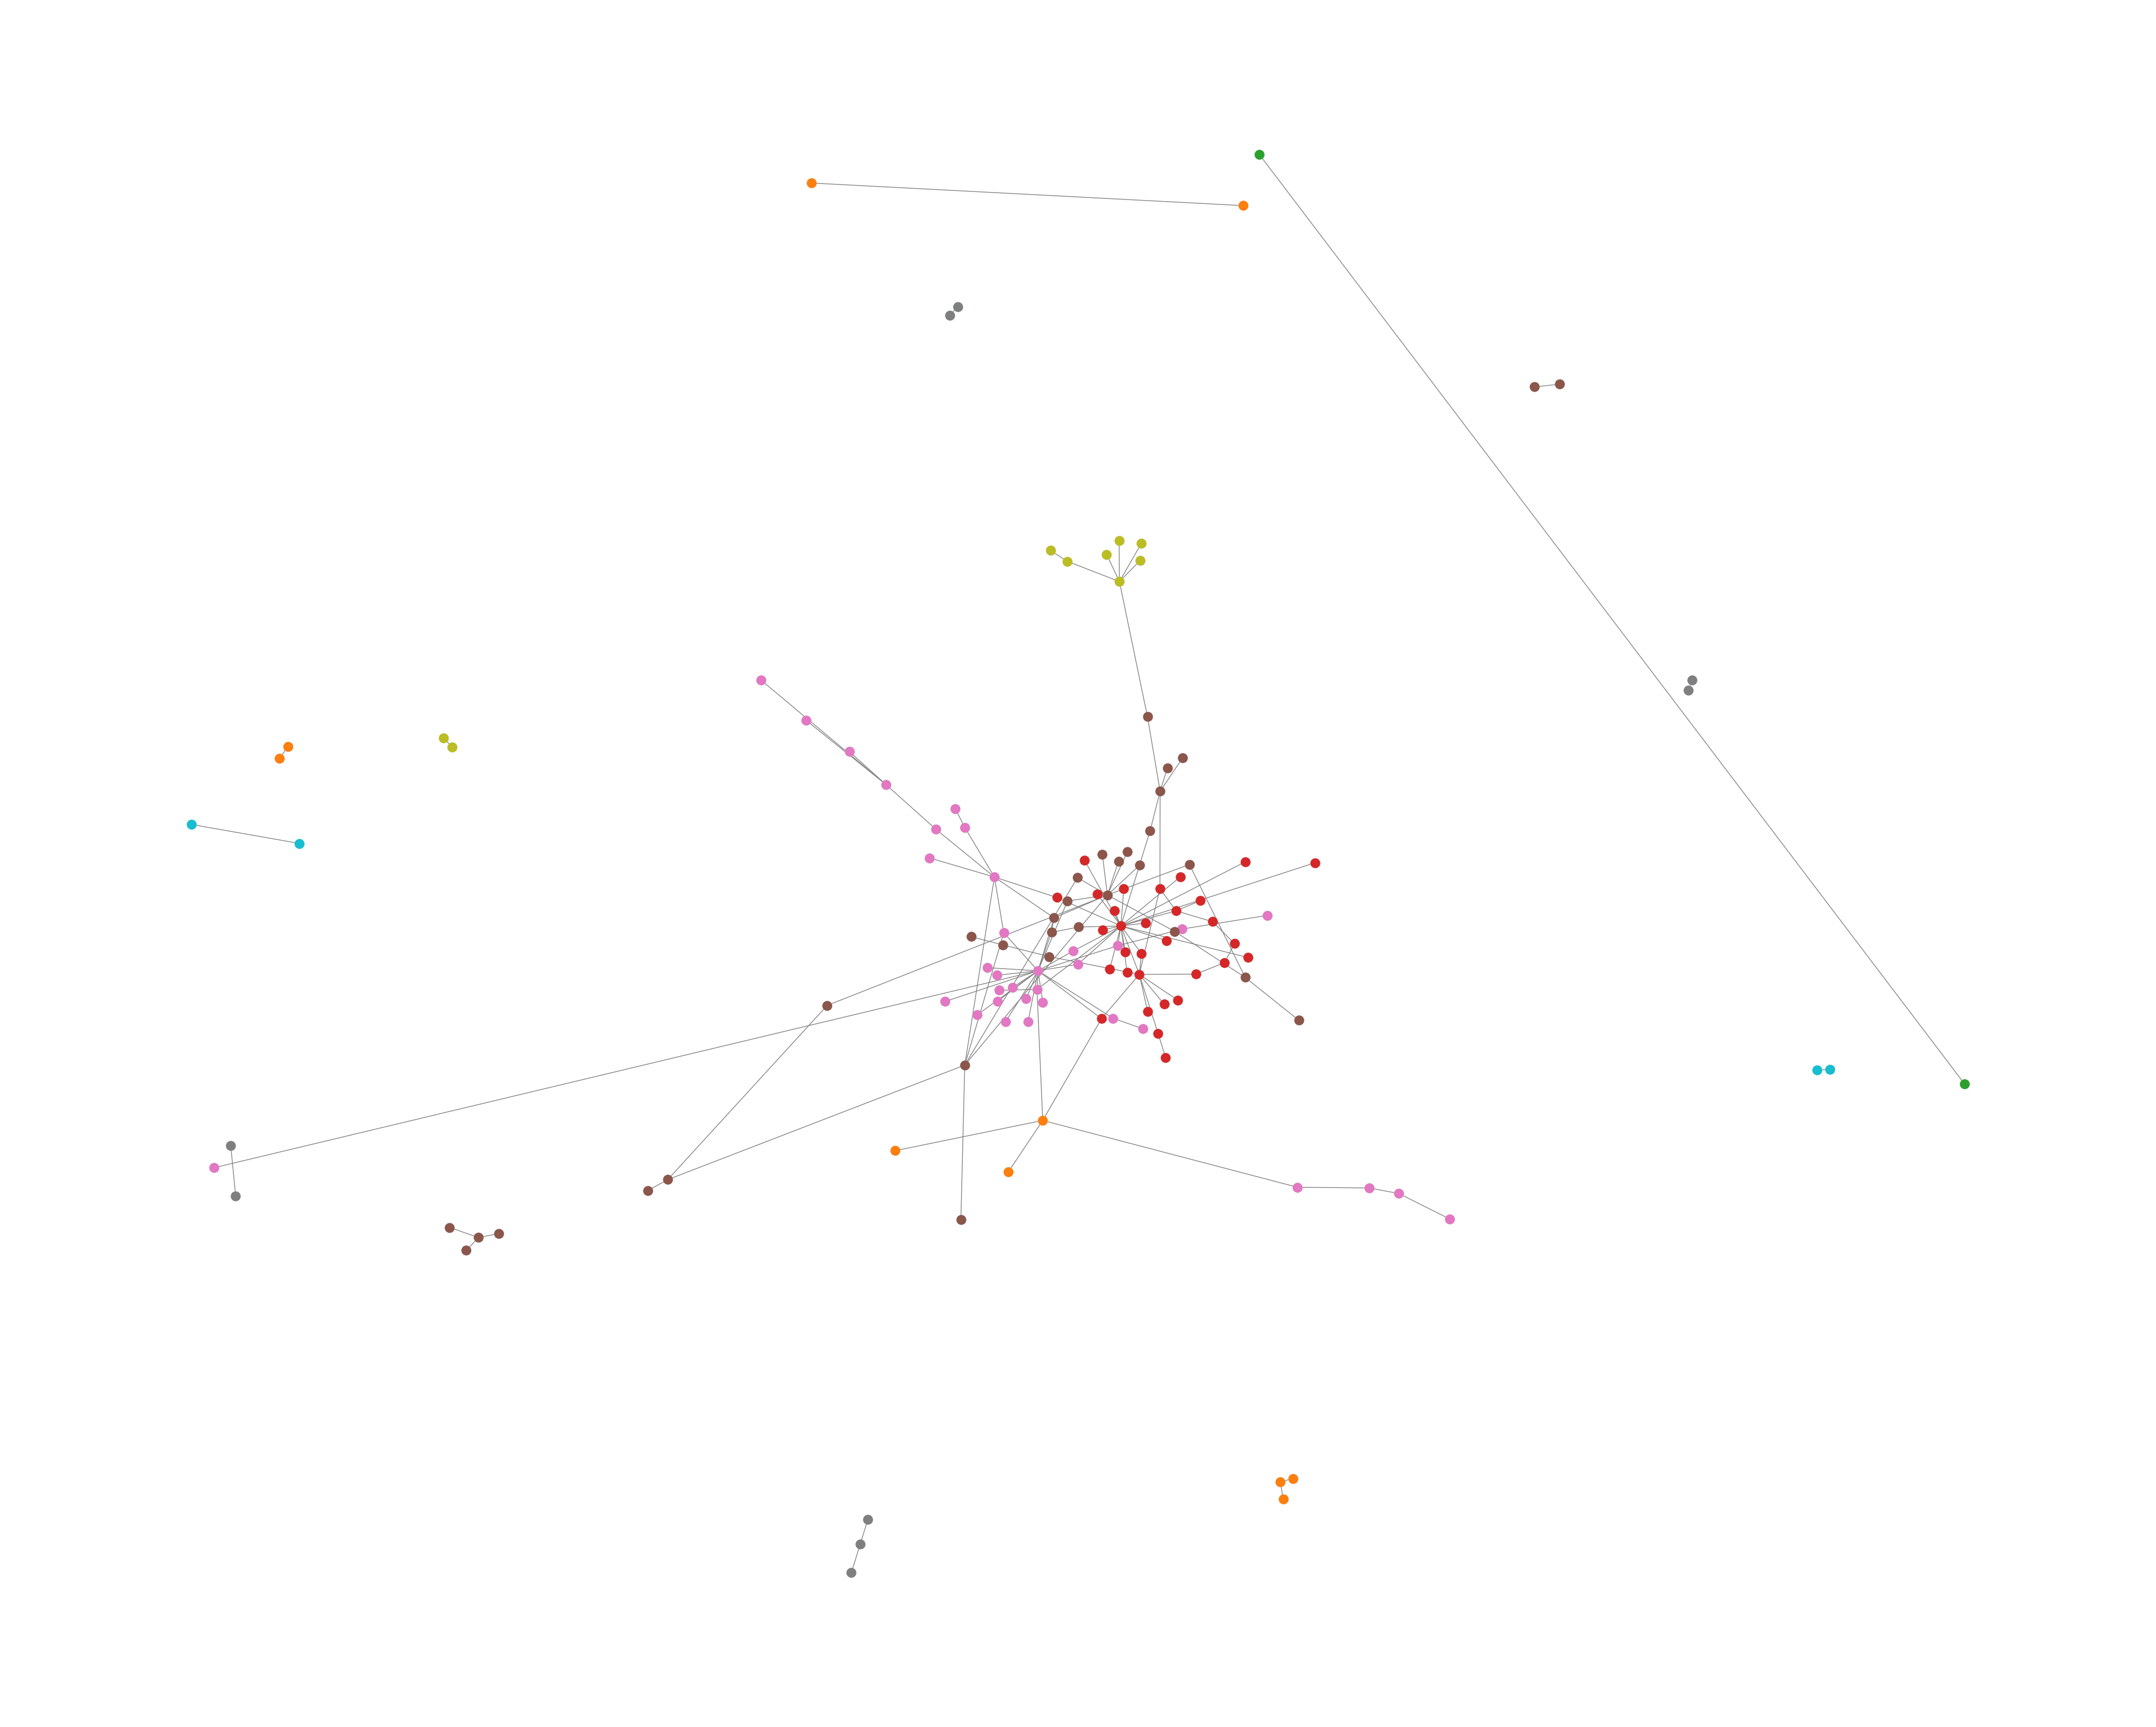

In [365]:
plt.figure(figsize=(40, 32))
pos = nx.spring_layout(G)

nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray',node_size=150)
for node in G.nodes():
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=f'C{f[1][node]}',node_size=150)

plt.savefig('ex5.png')

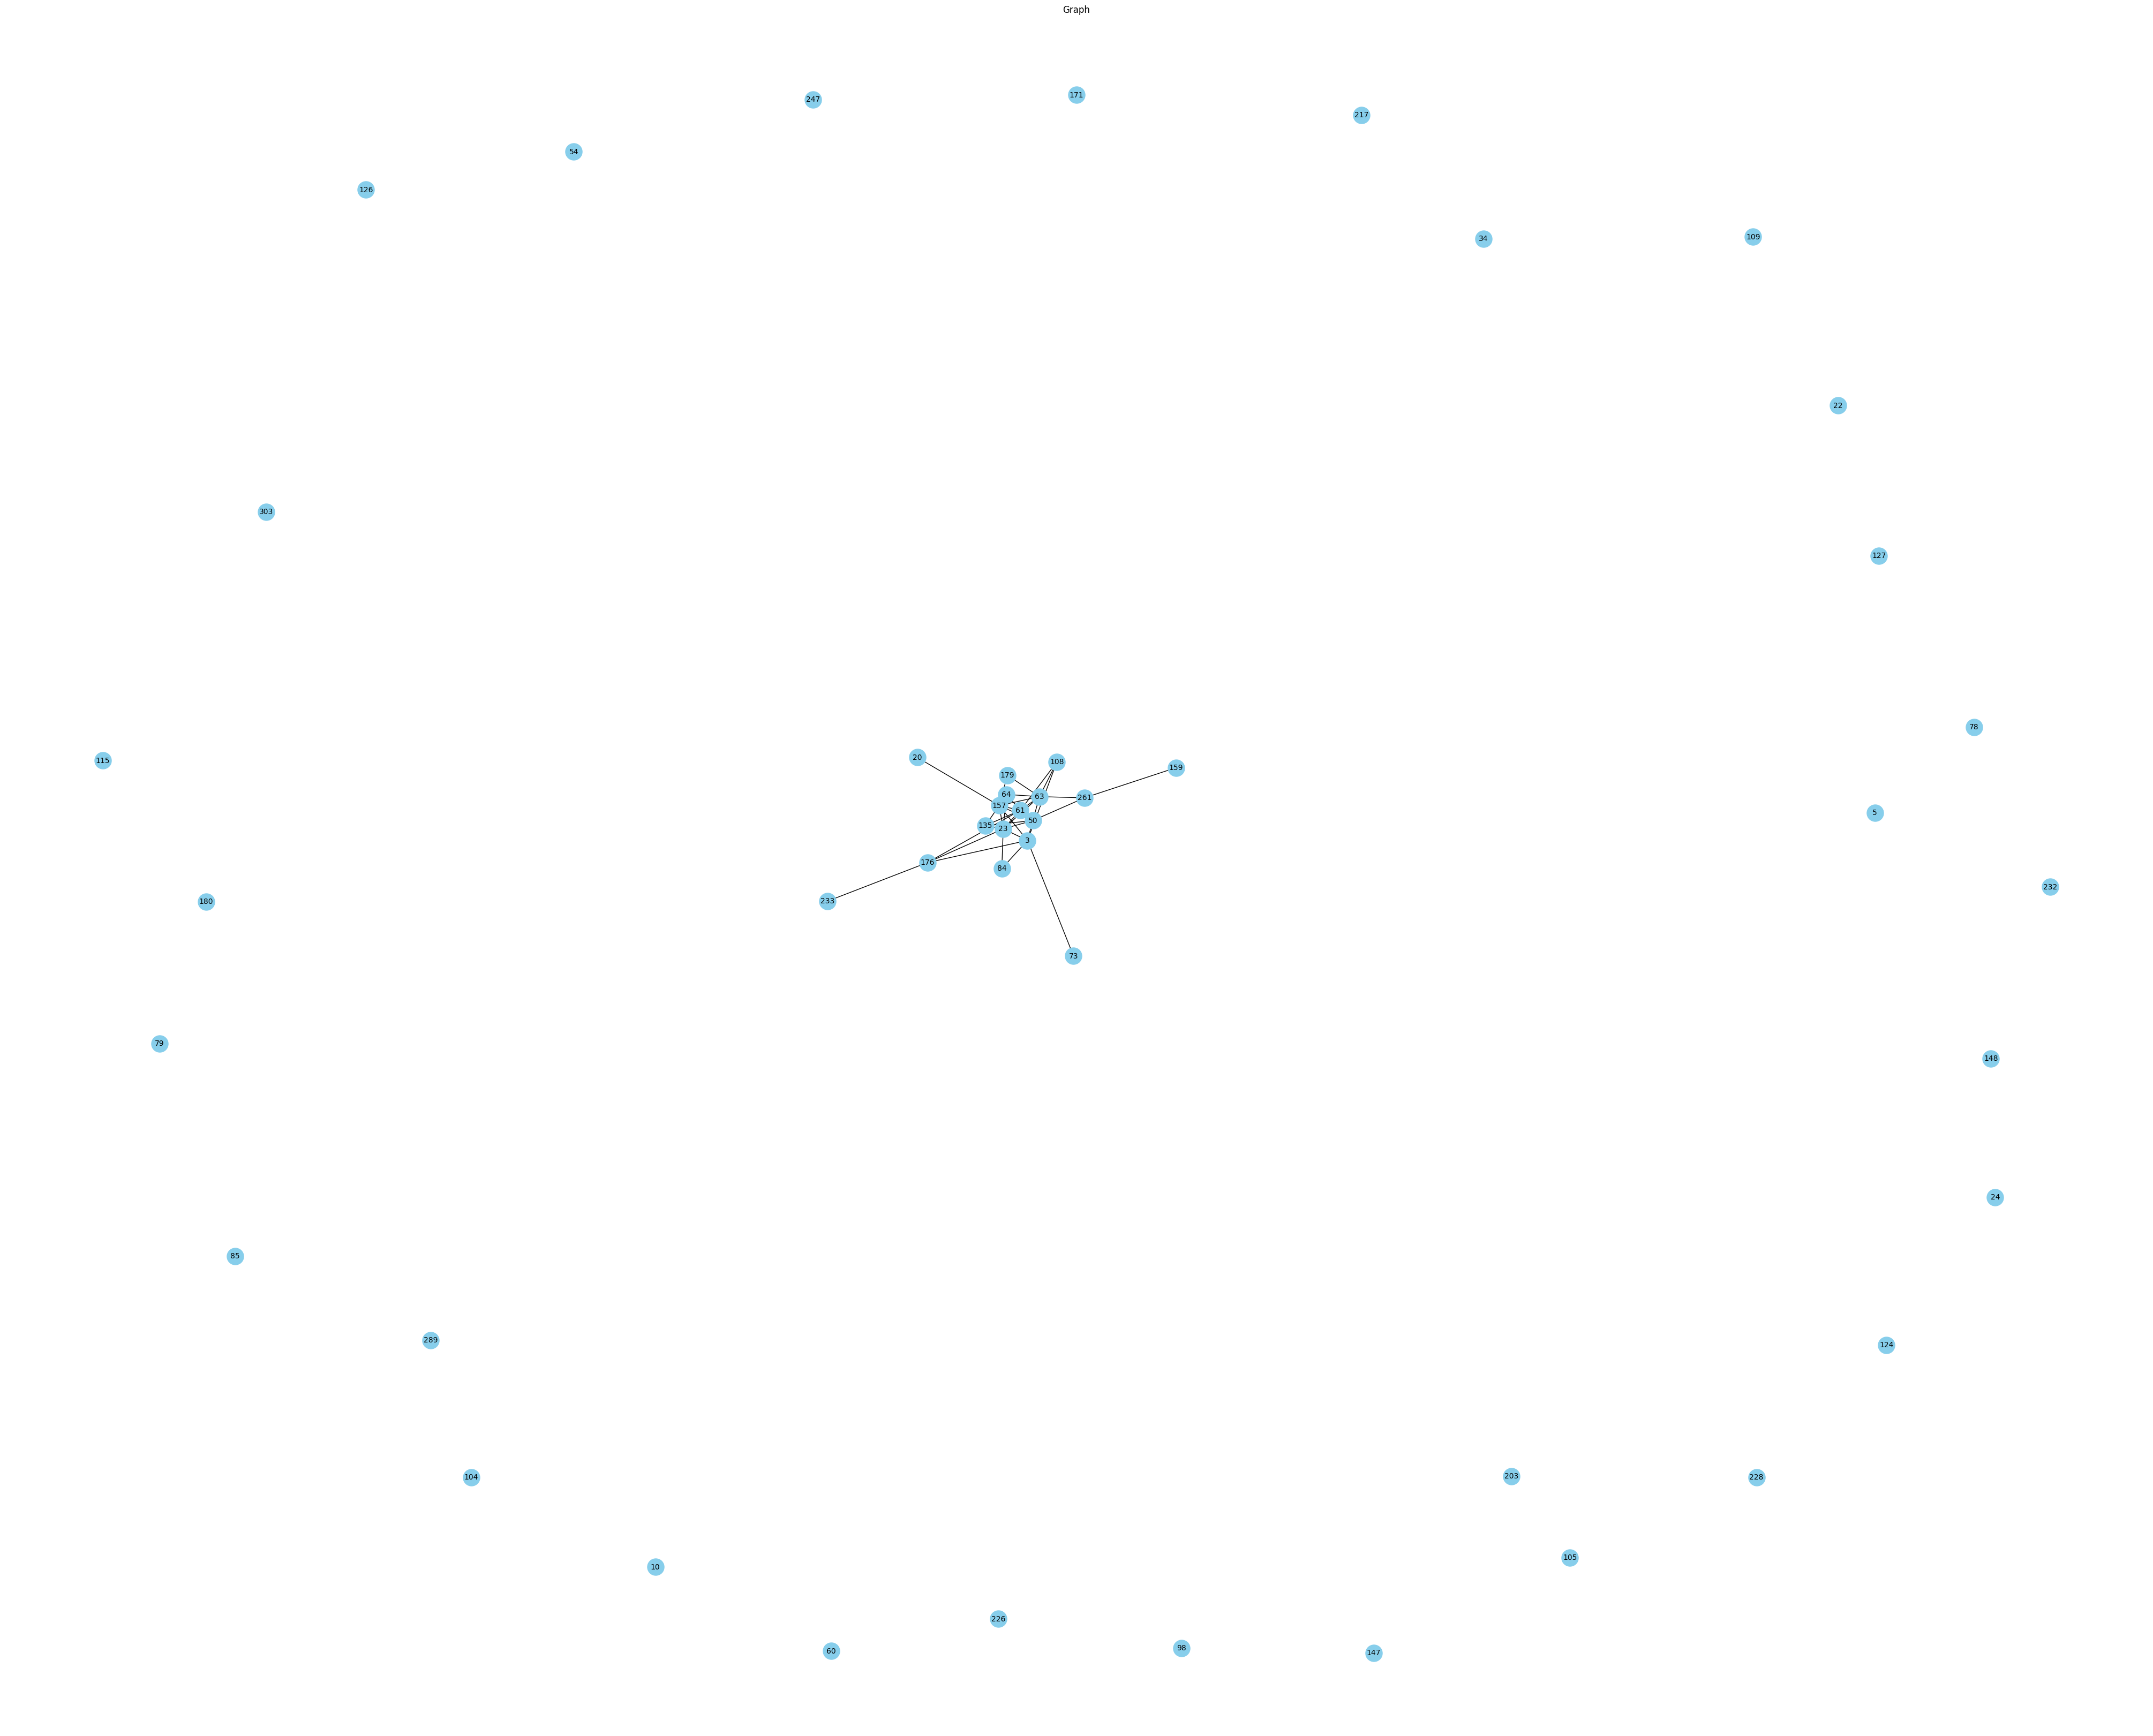

In [311]:
plt.figure(figsize=(40, 32))
pos = nx.spring_layout(gr[2])  
nx.draw(gr[2], pos, with_labels=True, node_color='skyblue', node_size=500, font_size=10)  

plt.title('Graph') 
plt.savefig('ex6.png')

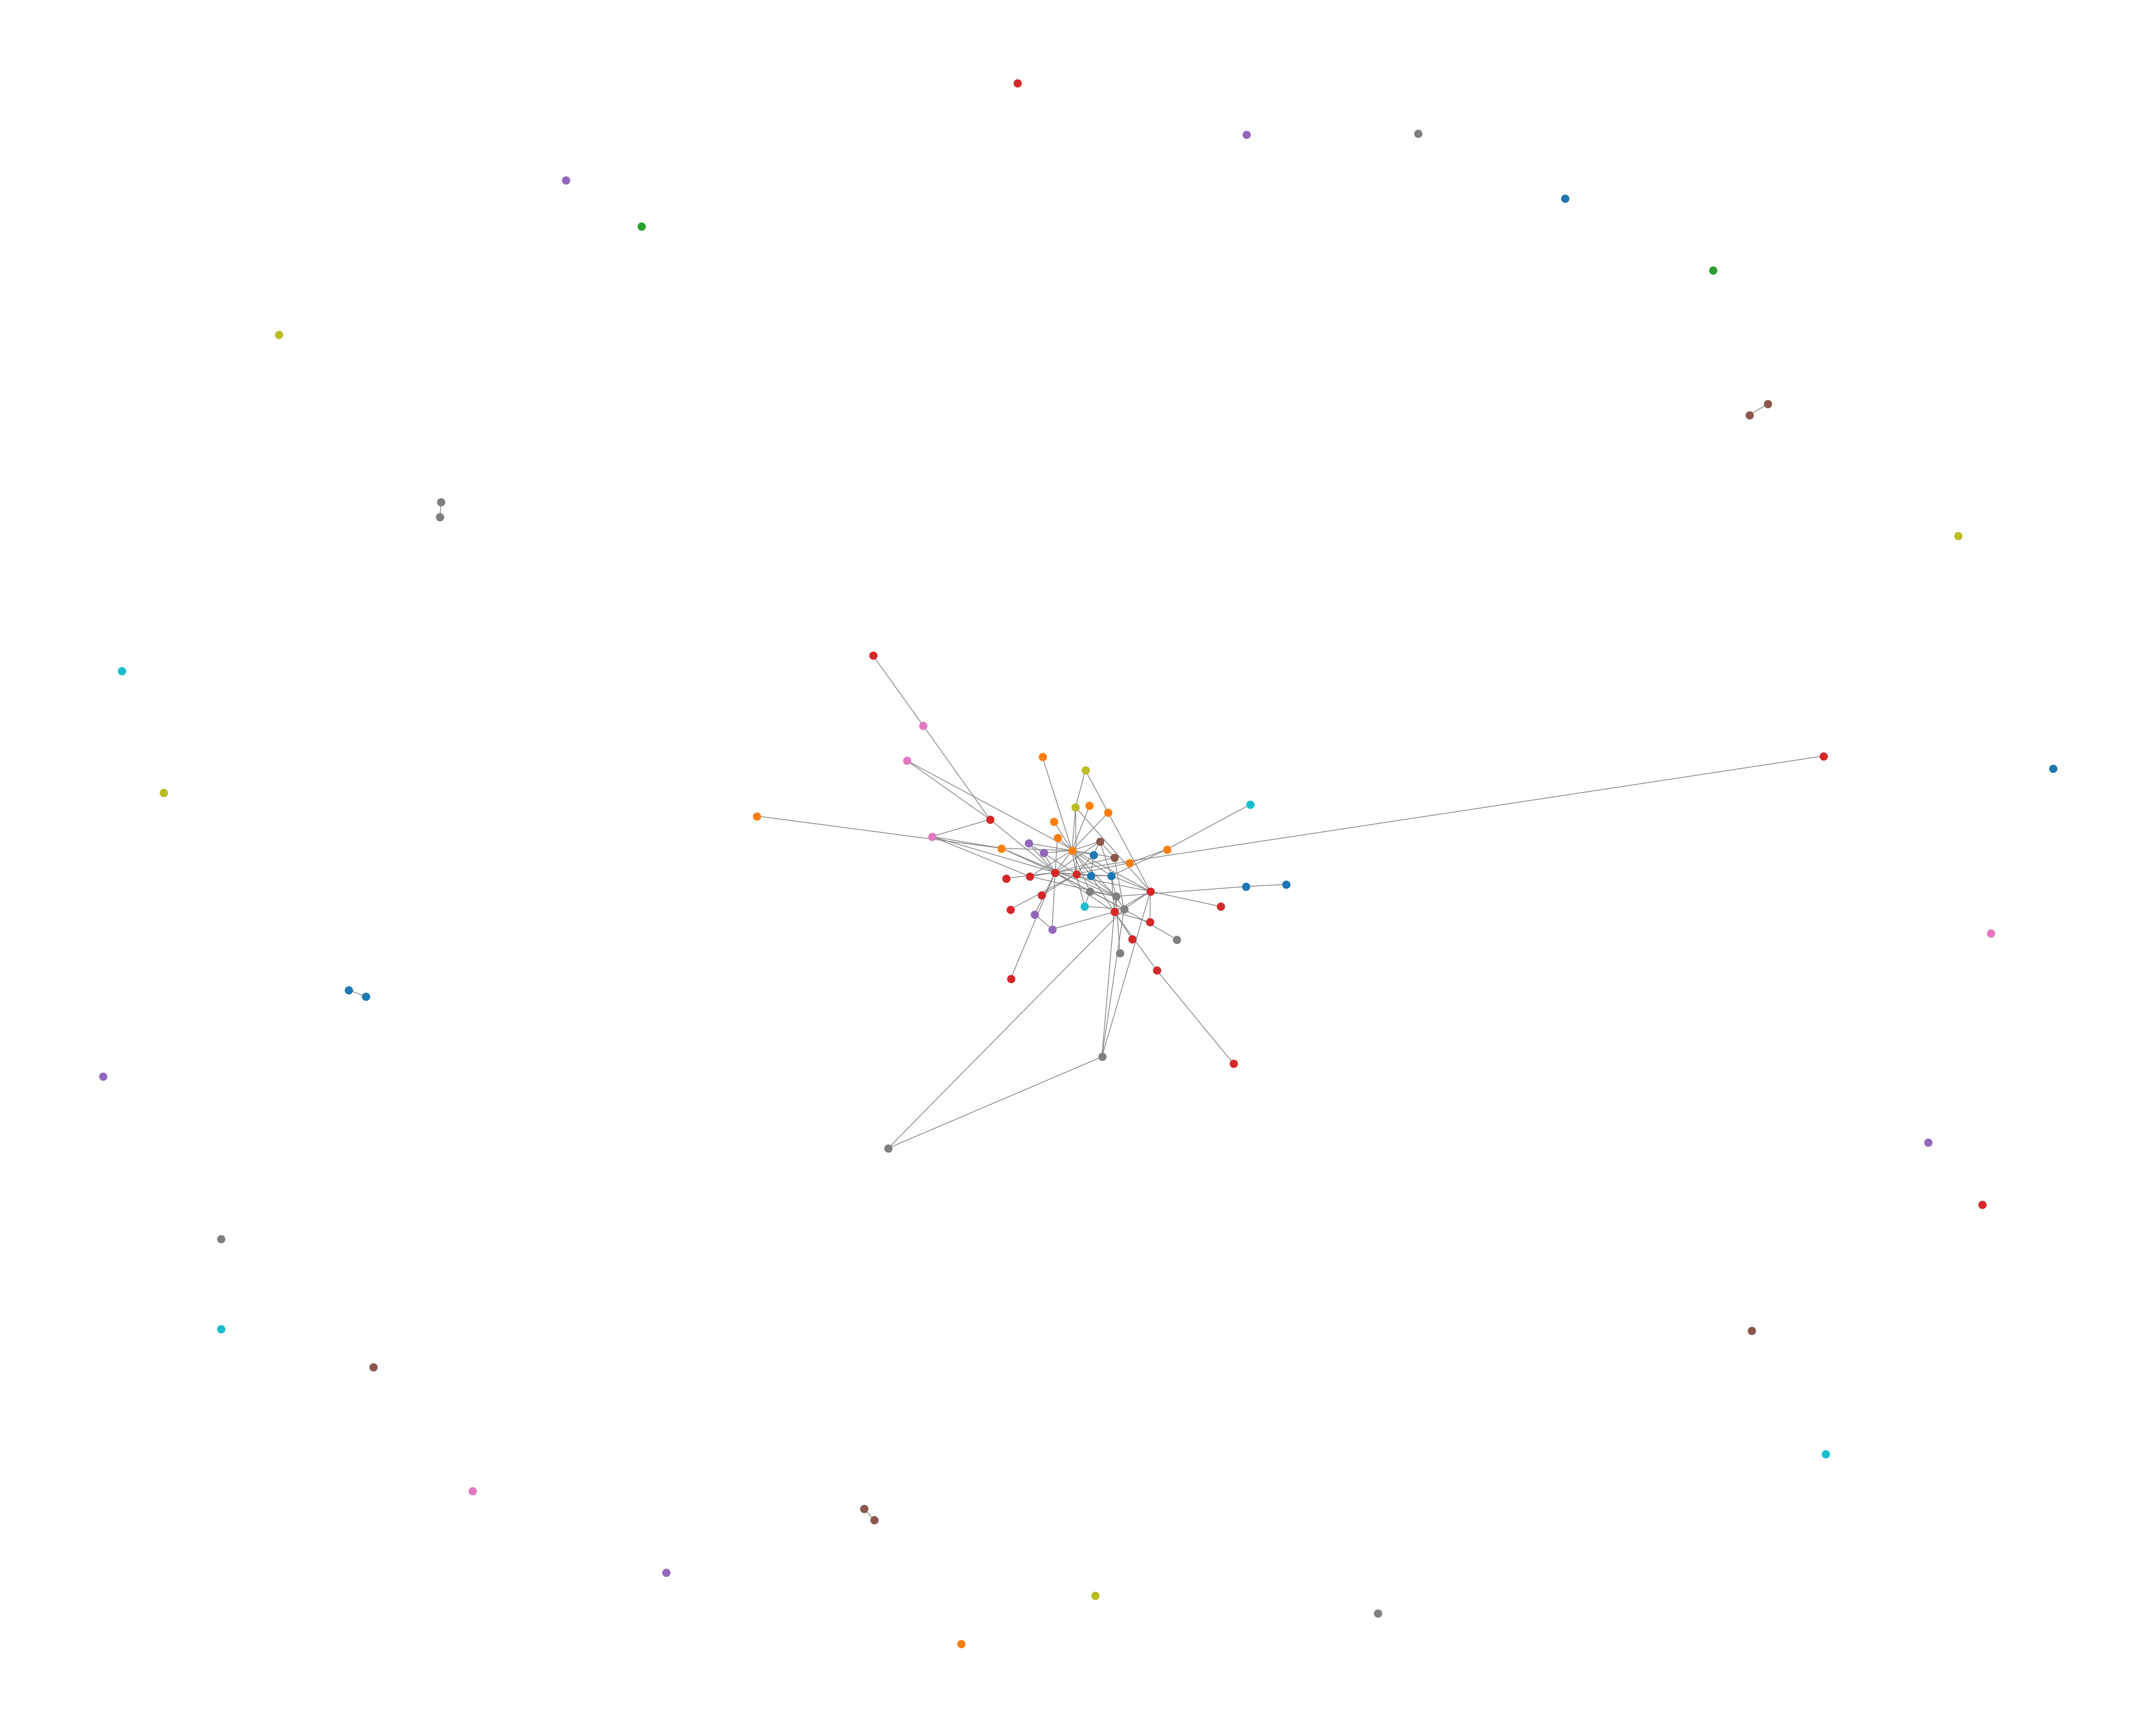

In [309]:
plt.figure(figsize=(40, 32))
pos = nx.spring_layout(gr[1])

nx.draw(gr[1], pos, with_labels=False, node_color='lightblue', edge_color='gray',node_size=100)
for node in gr[1].nodes():
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=f'C{p[1][node]}',node_size=100)

plt.savefig('ex4.png')

In [71]:
file_path = 'ex.gml' 
#file_path = 'LR_graph_visu-merged.gml' 

G = read_graph_from_gml(file_path)

p, f, gr, num = louvain_until_convergence(G)

In [28]:
print(calculate_modularity(G, f[1]))

IndexError: list index out of range

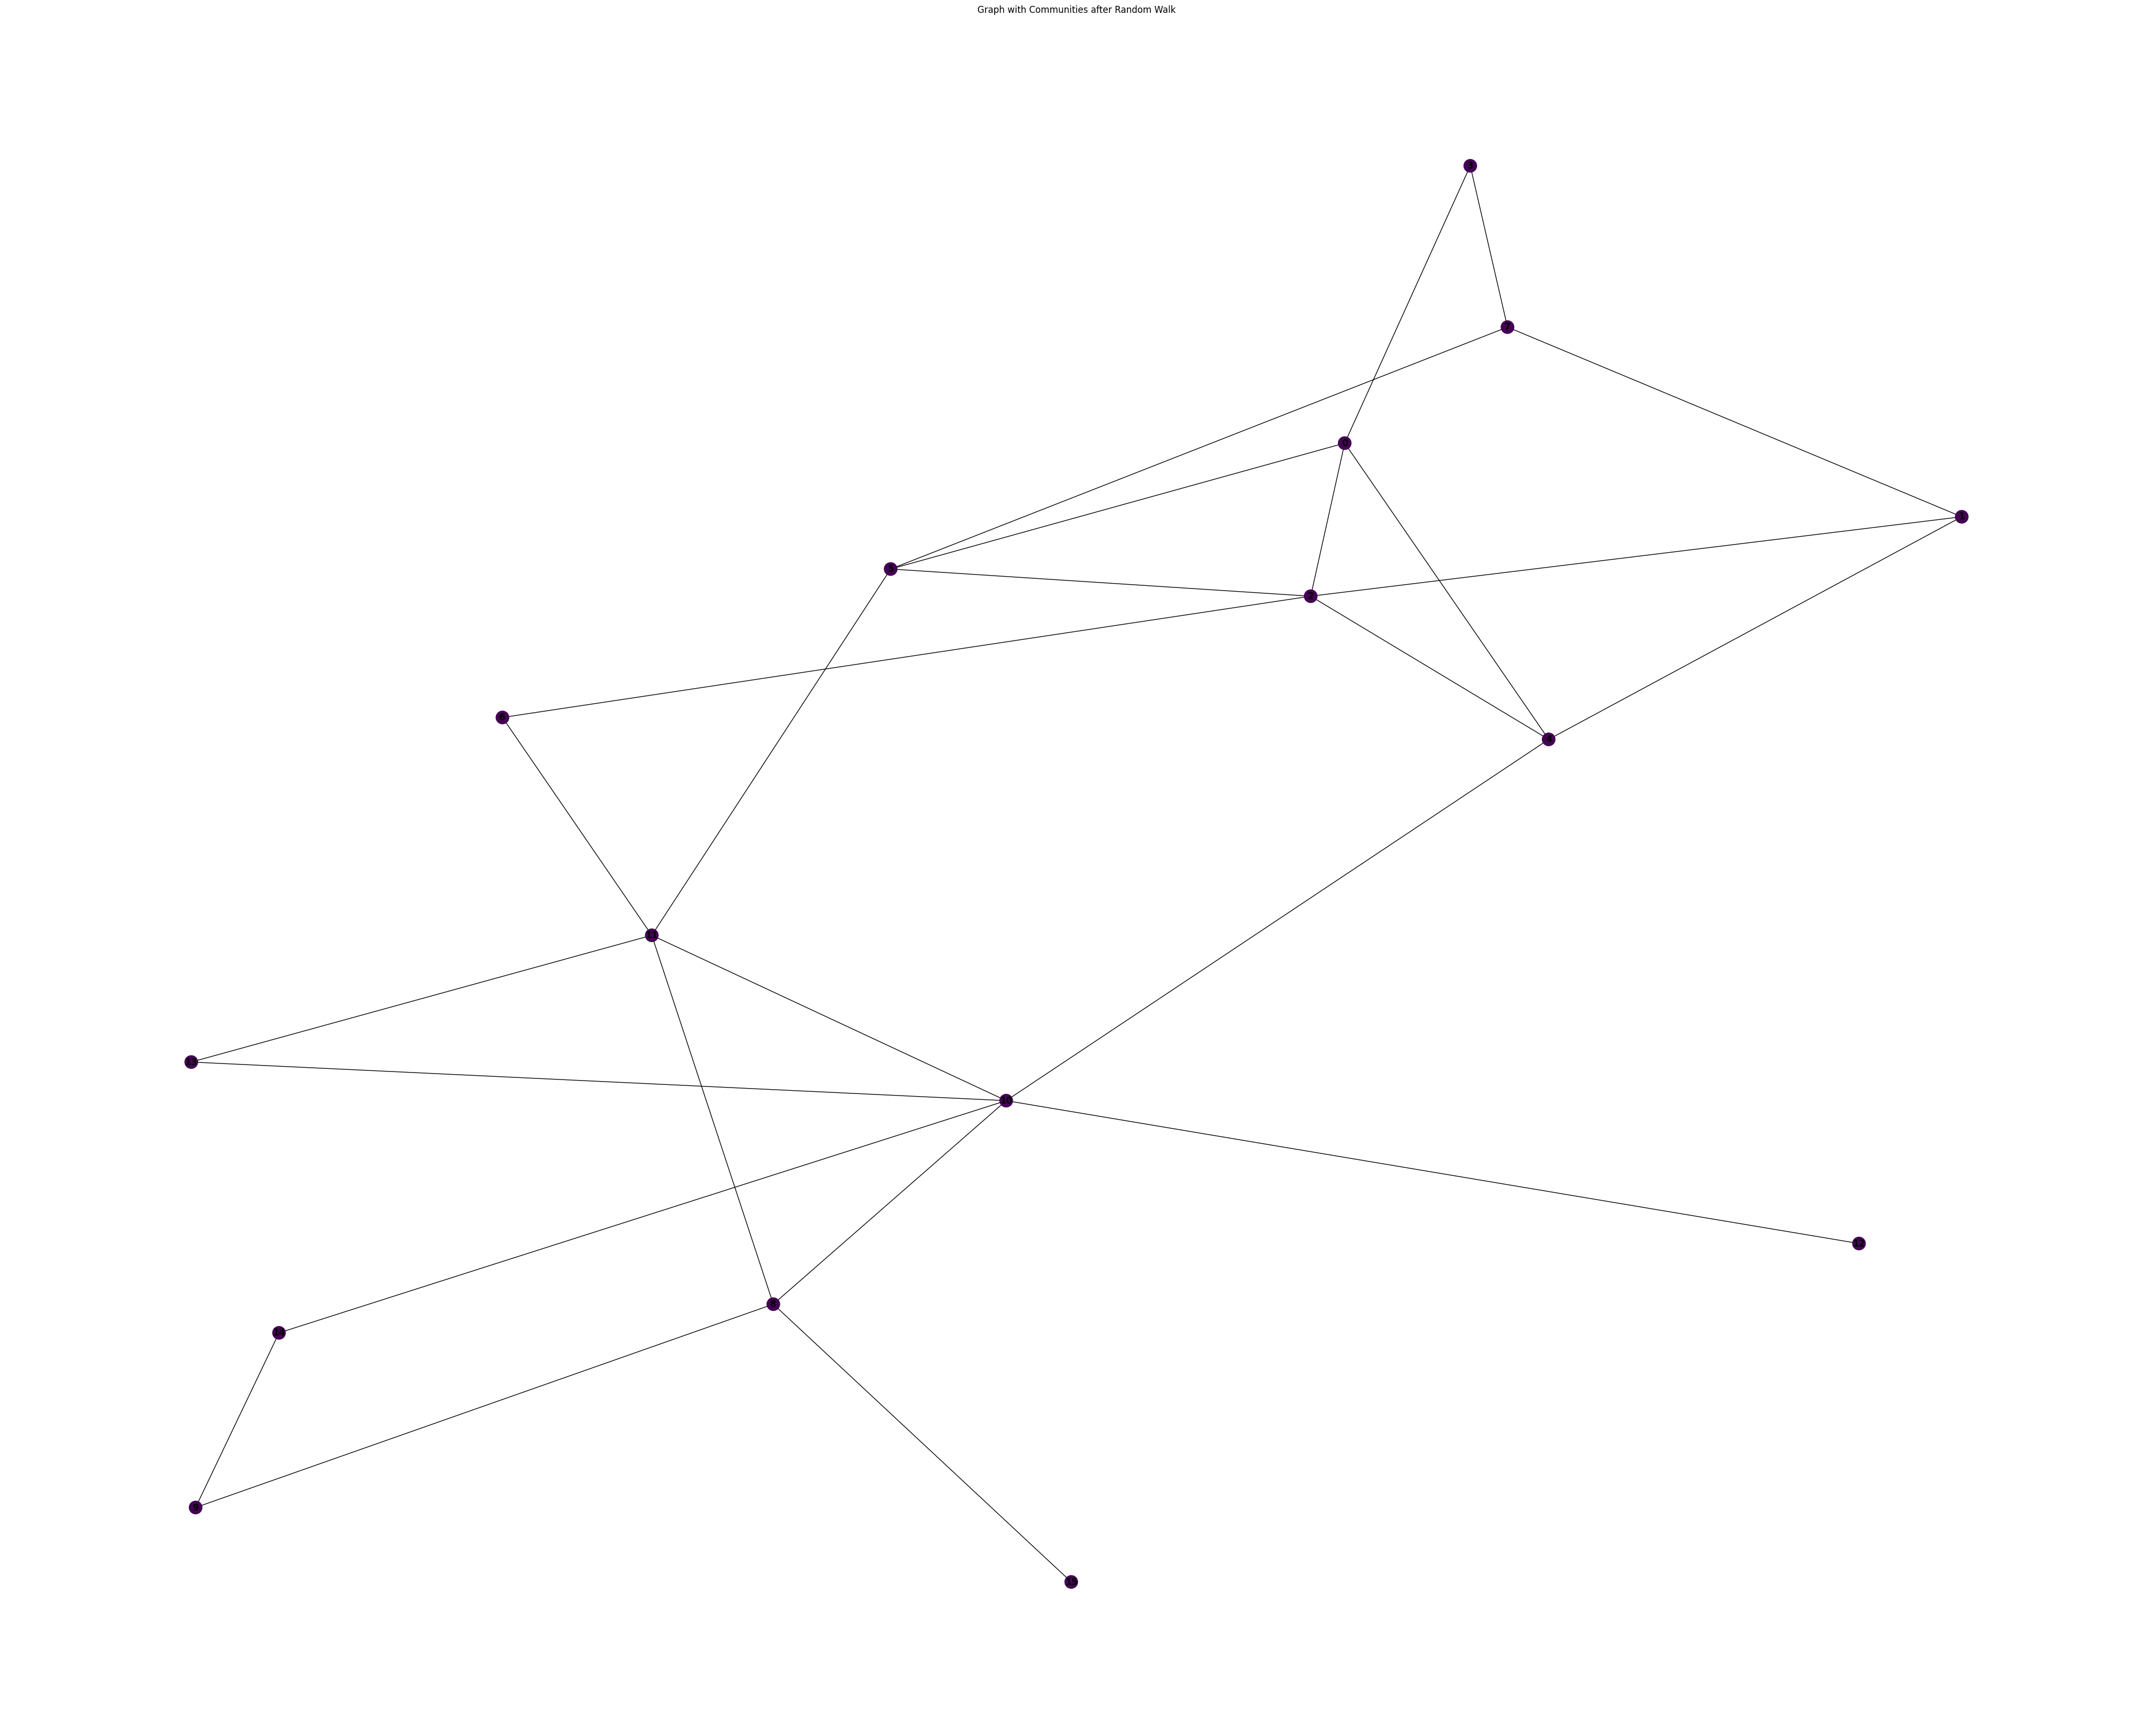

In [74]:
colors = [f[1][node] for node in G.nodes()]
plt.figure(figsize=(40, 32))
nx.draw(G, with_labels=True, font_weight='bold', node_color=colors, cmap='viridis')
plt.title('Graph with Communities after Random Walk')
plt.savefig('1.png')

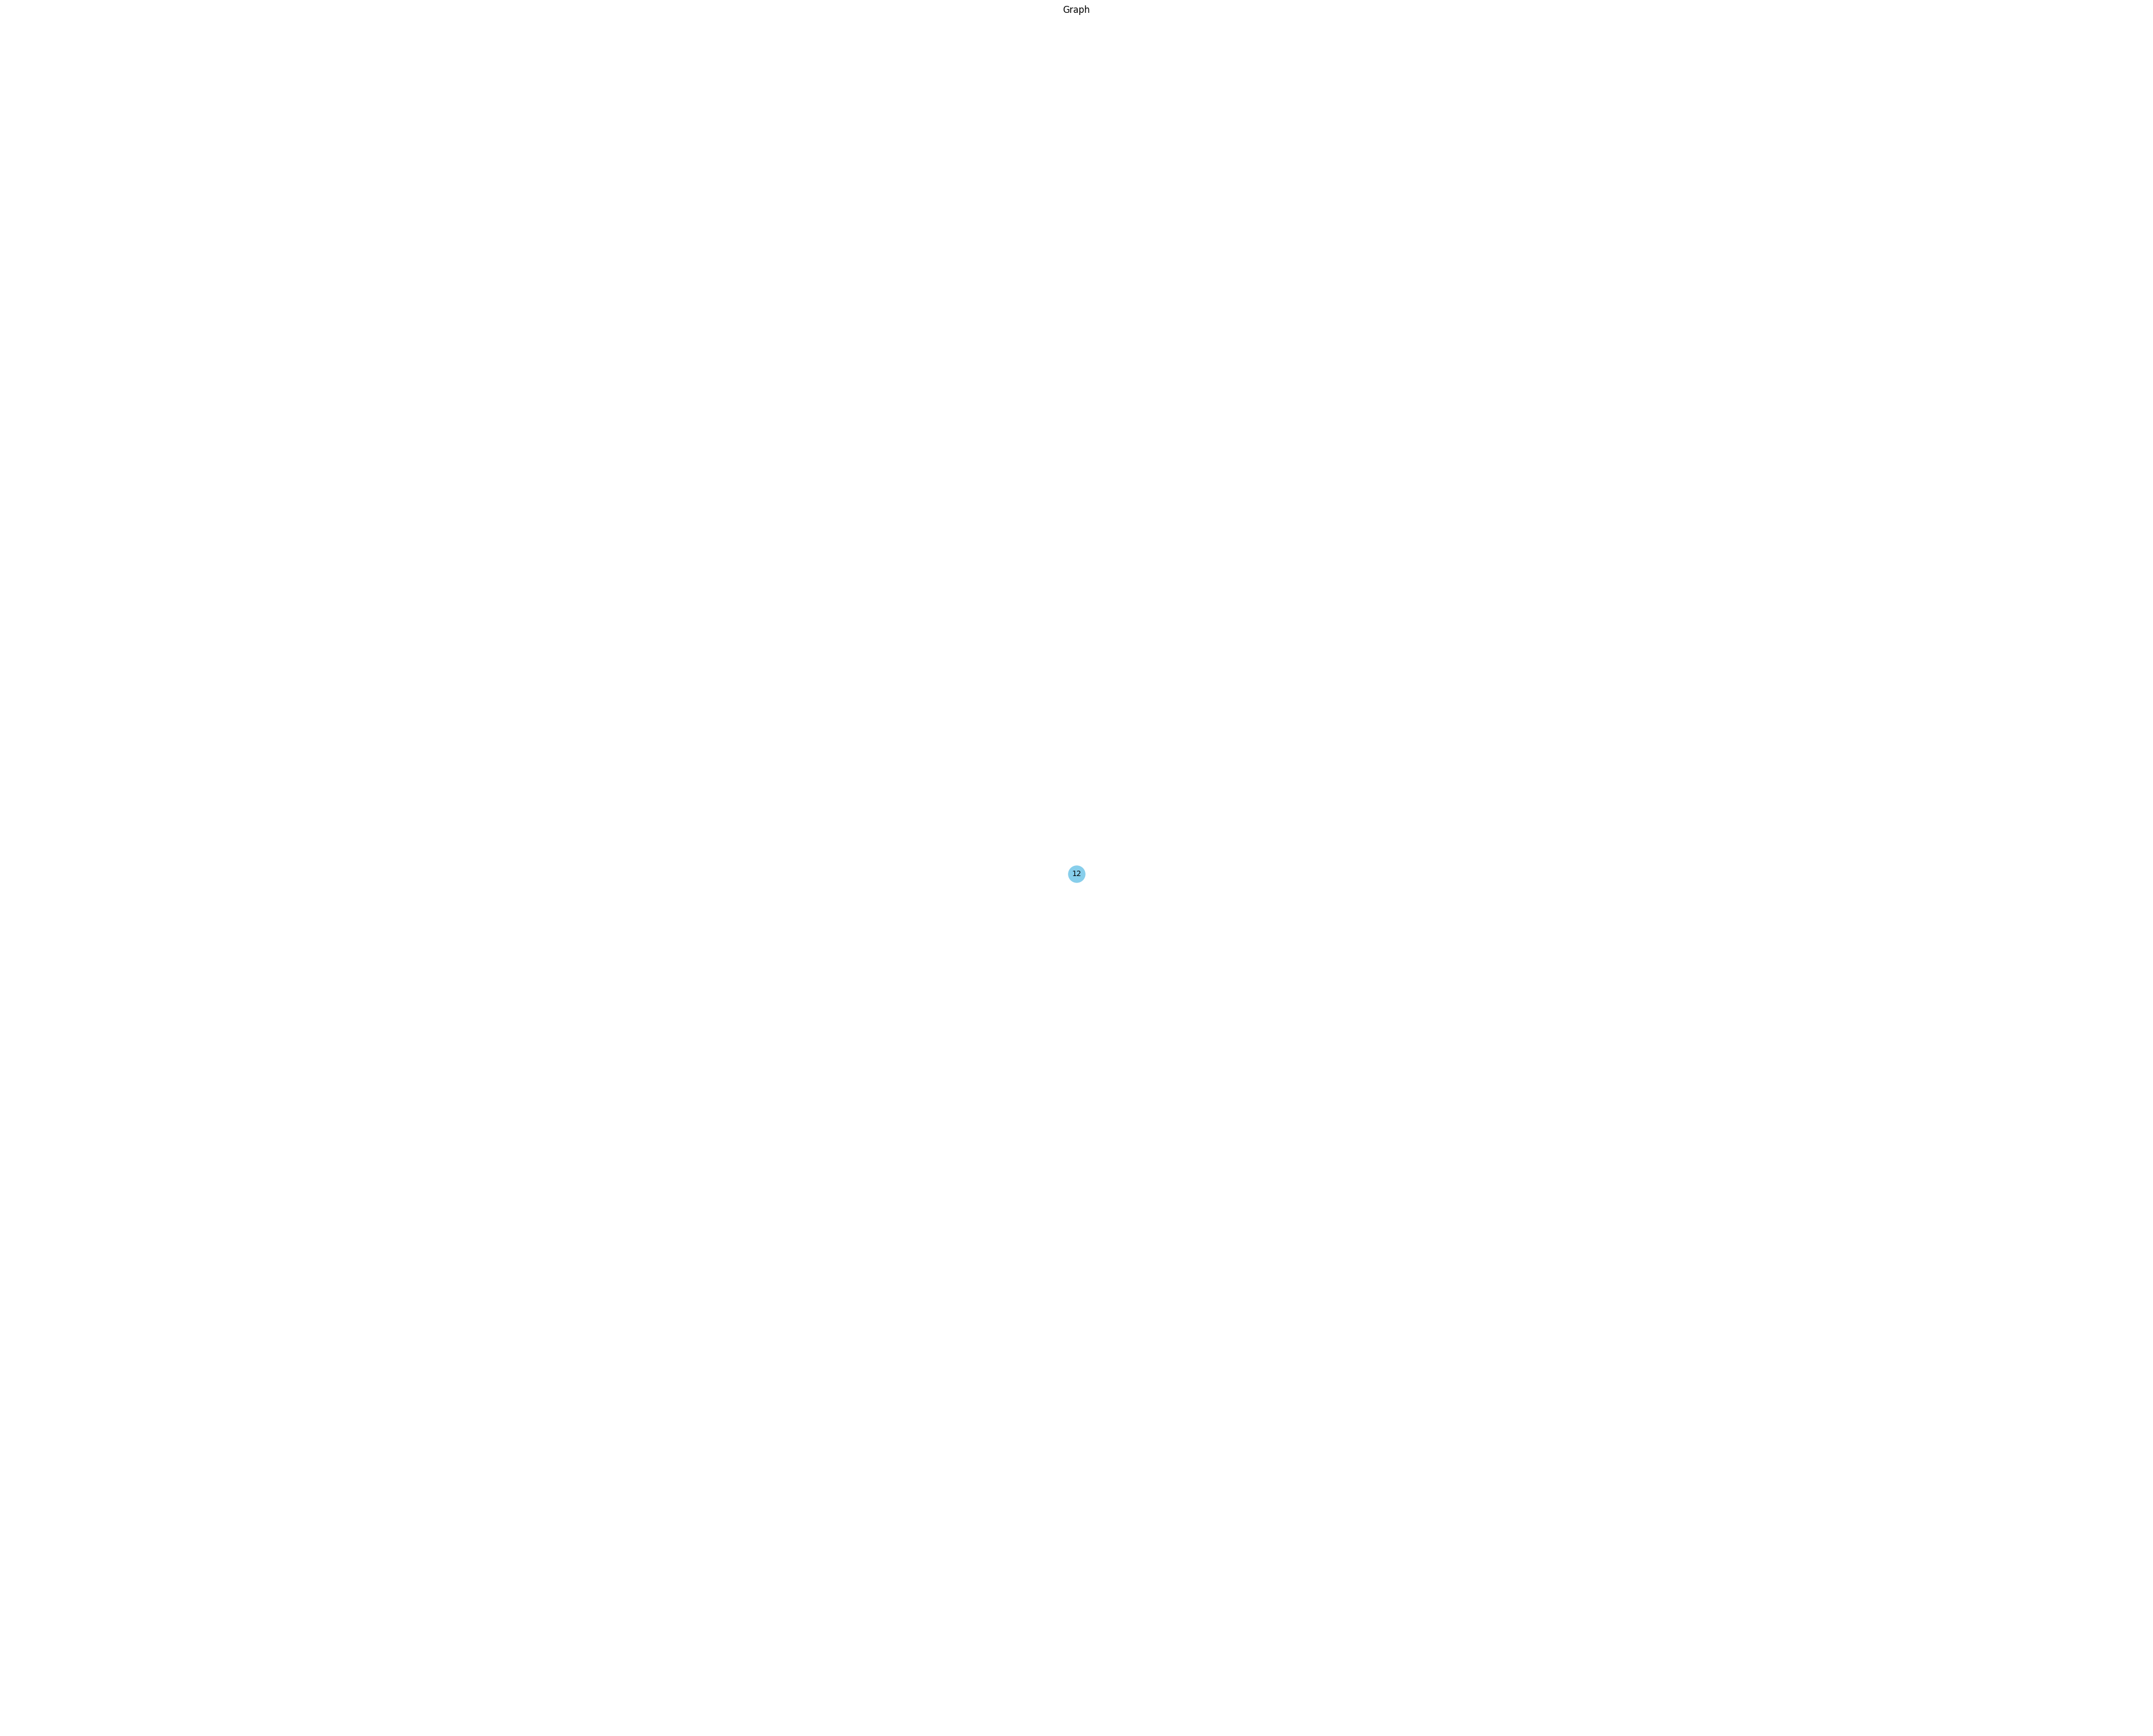

In [77]:
plt.figure(figsize=(40, 32))
pos = nx.spring_layout(gr[0])  
nx.draw(gr[2], pos, with_labels=True, node_color='skyblue', node_size=500, font_size=10)  

plt.title('Graph') 
plt.savefig('1.png')

In [24]:
file_path = 'ex.gml' 
#file_path = 'LR_graph_visu-merged.gml' 

G = read_graph_from_gml(file_path)

p, f, gr, num = louvain_until_convergence(G)

0
2.0
1
6.0
2
4.0
0
2.0
0
4.0
1
4.0
1
6.0
2
4.0
0
2.0
0
4.0
1
4.0
1
6.0
2
4.0
0
2.0
1
6.0
1
5.0
2
5.0
2
4.0
0
2.0
0
4.0
1
4.0
1
6.0
2
4.0
0
2.0
1
6.0
1
5.0
2
5.0
2
4.0
0
2.0
1
6.0
1
5.0
2
5.0
2
4.0
0
2.0
1
6.0
1
5.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.0
1
4.0
1
6.0
1
5.0
2
3.0
2
5.0
2
4.0
0
2.0
0
4.0
0
3.

In [36]:
print(calculate_modularity(G, f[0])*10000000000000)

0.0001850371707708594


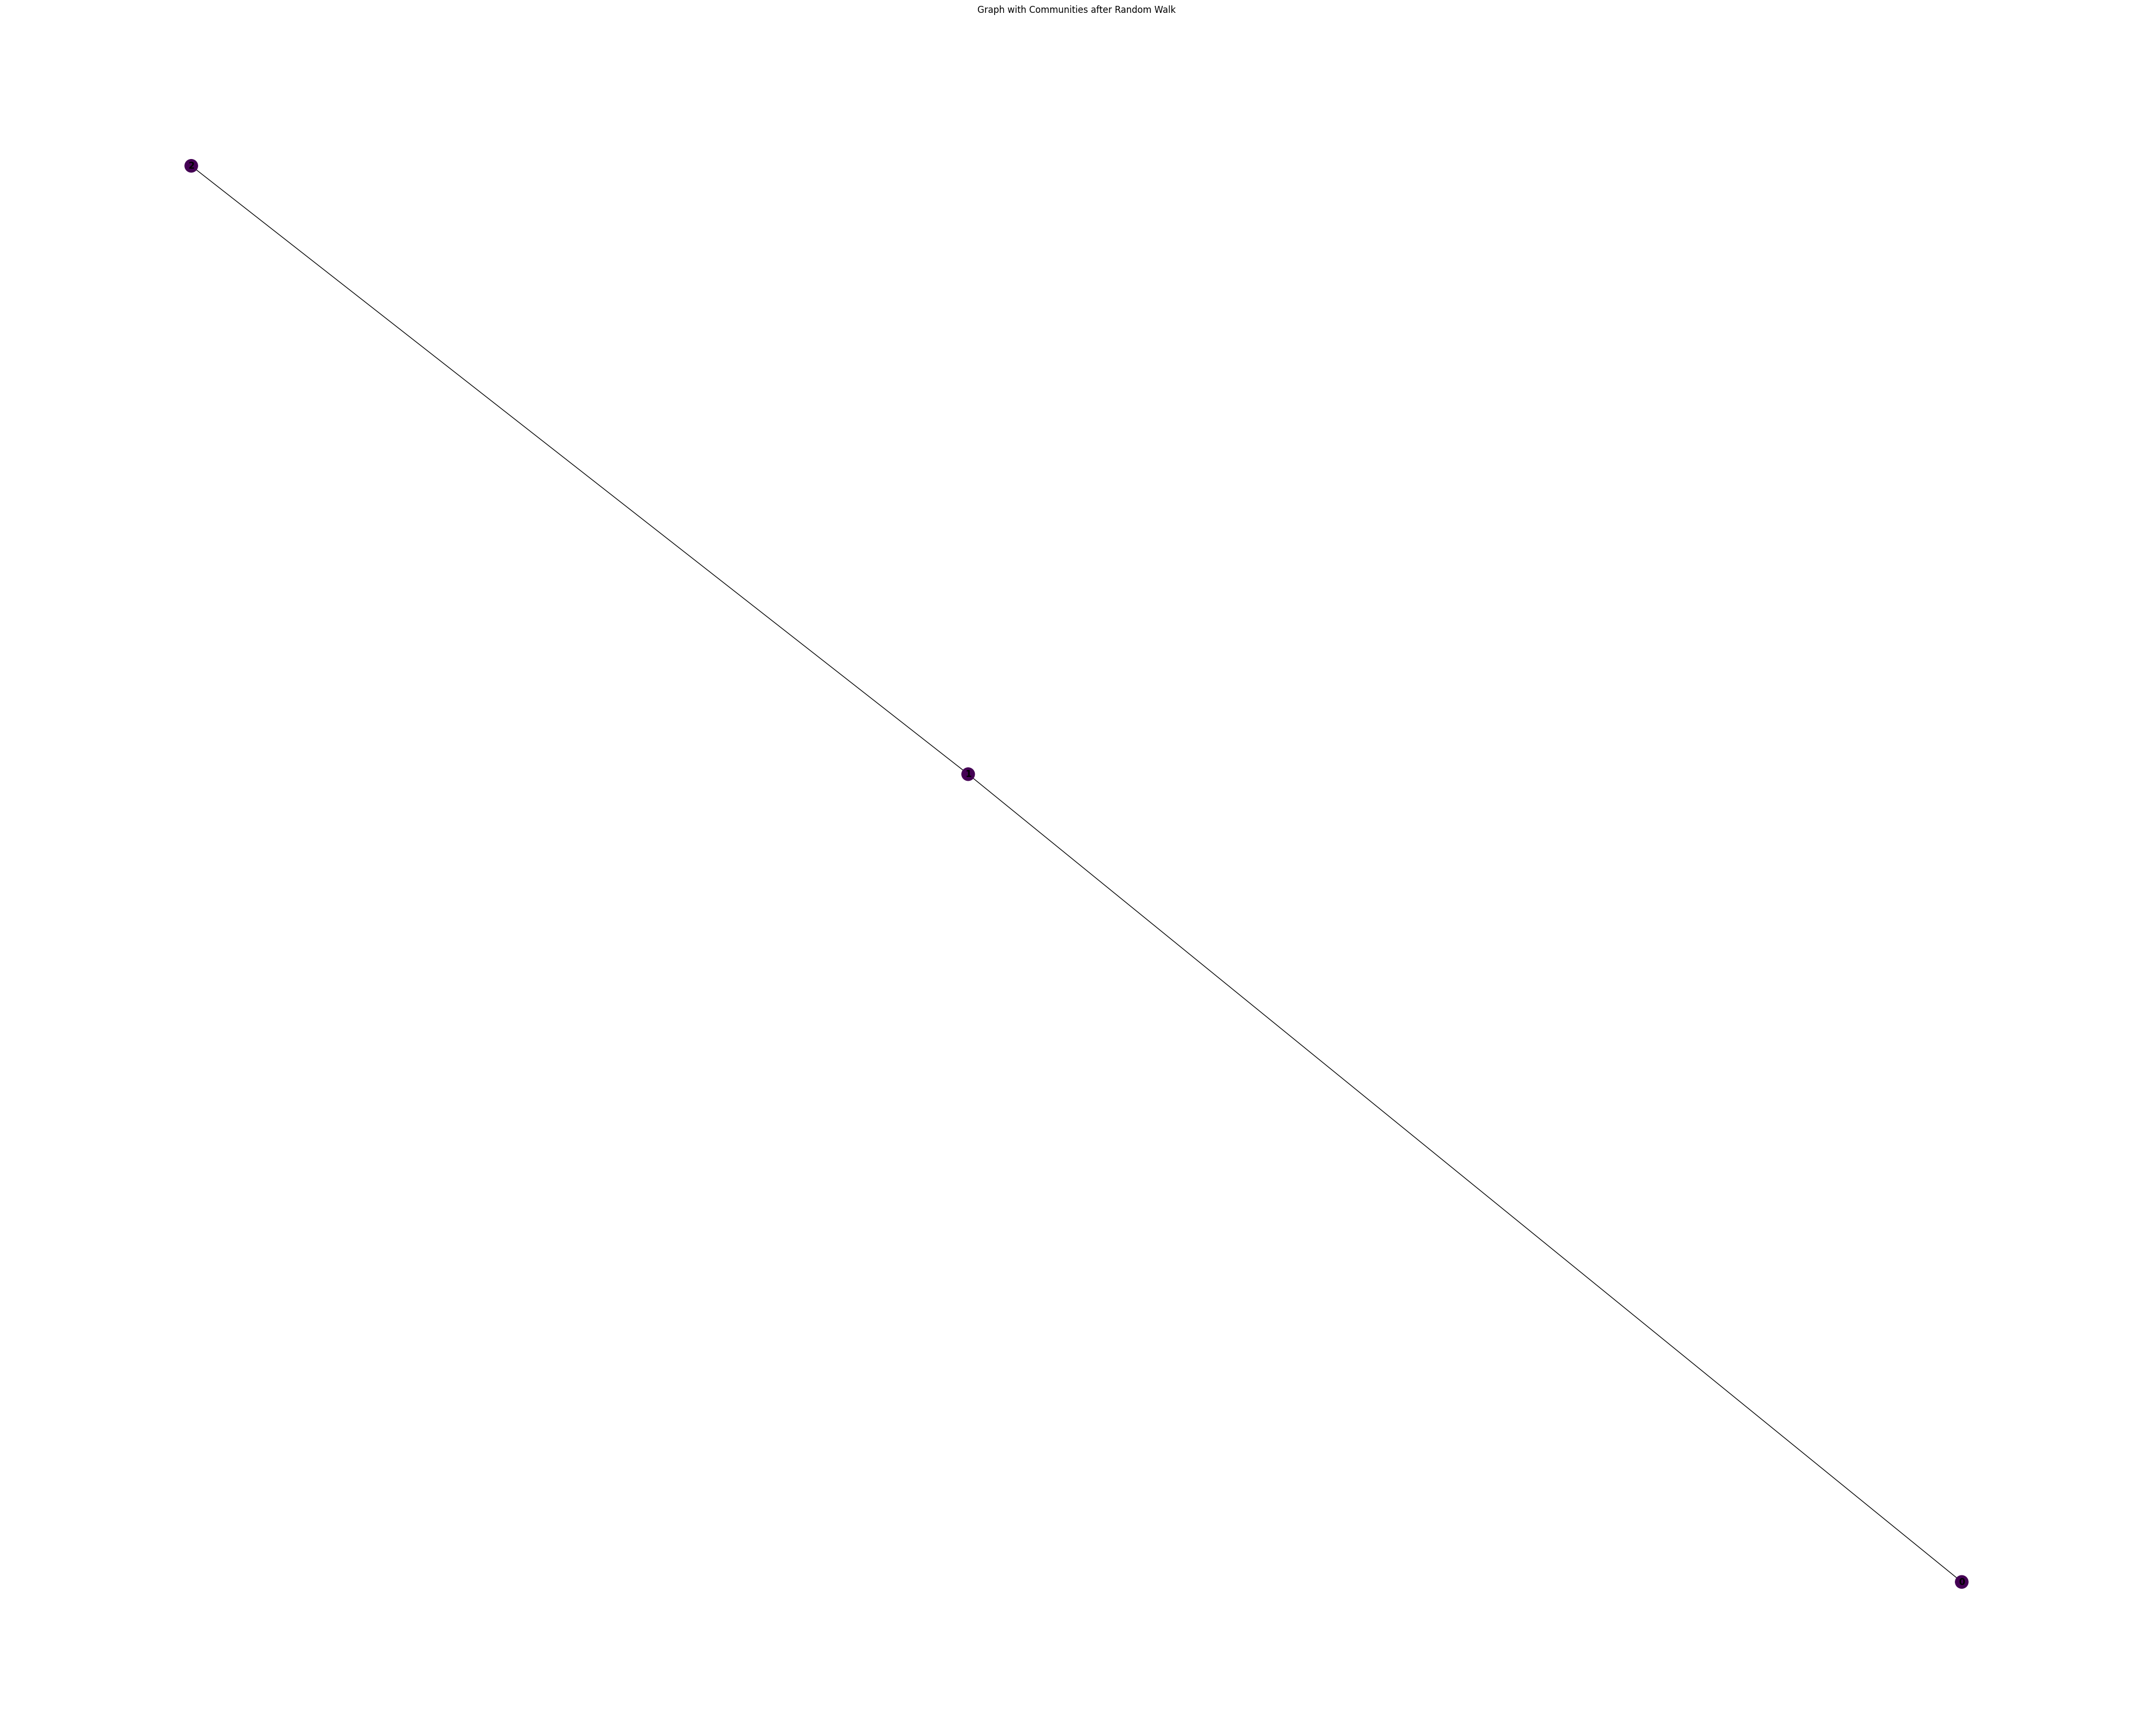

In [23]:
colors = [f[0][node] for node in G.nodes()]
plt.figure(figsize=(40, 32))
nx.draw(G, with_labels=True, font_weight='bold', node_color=colors, cmap='viridis')
plt.title('Graph with Communities after Random Walk')
plt.savefig('ex1_8.png')

In [171]:
import networkx as nx
from networkx.algorithms.community import louvain


file_path = 'LR_graph_visu-merged.gml' 

G = read_graph_from_gml(file_path)
partition = louvain(G)


TypeError: 'module' object is not callable

In [247]:
import networkx as nx
file_path = 'LR_graph_visu-merged.gml' 

G = read_graph_from_gml(file_path)

community = nx.community.louvain_partitions(G)

In [205]:
print(community)

<generator object louvain_partitions at 0x14c511fc0>


In [366]:
#file_path = 'LR_graph_Macrophages_Tcells.gml' 
#file_path = 'LR_graph_visu-merged.gml' 
file_path = 'corr_distance_Macrophages.gml'

G = read_graph_from_gml(file_path)
partitions = nx.community.louvain_partitions(G)

last_partition =0 
for level, partition in enumerate(partitions):
    modularity = nx.community.modularity(G, partition)
    print(f"Level {level}: Modularity = {modularity}")
    


Level 0: Modularity = 0.7229652301043794
Level 1: Modularity = 0.7779210598152797
Level 2: Modularity = 0.7780518073174483


In [279]:
import networkx as nx
file_path = 'corr_distance_Plasma-cells.gml' 

G = read_graph_from_gml(file_path)

community = nx.community.louvain_communities(G)

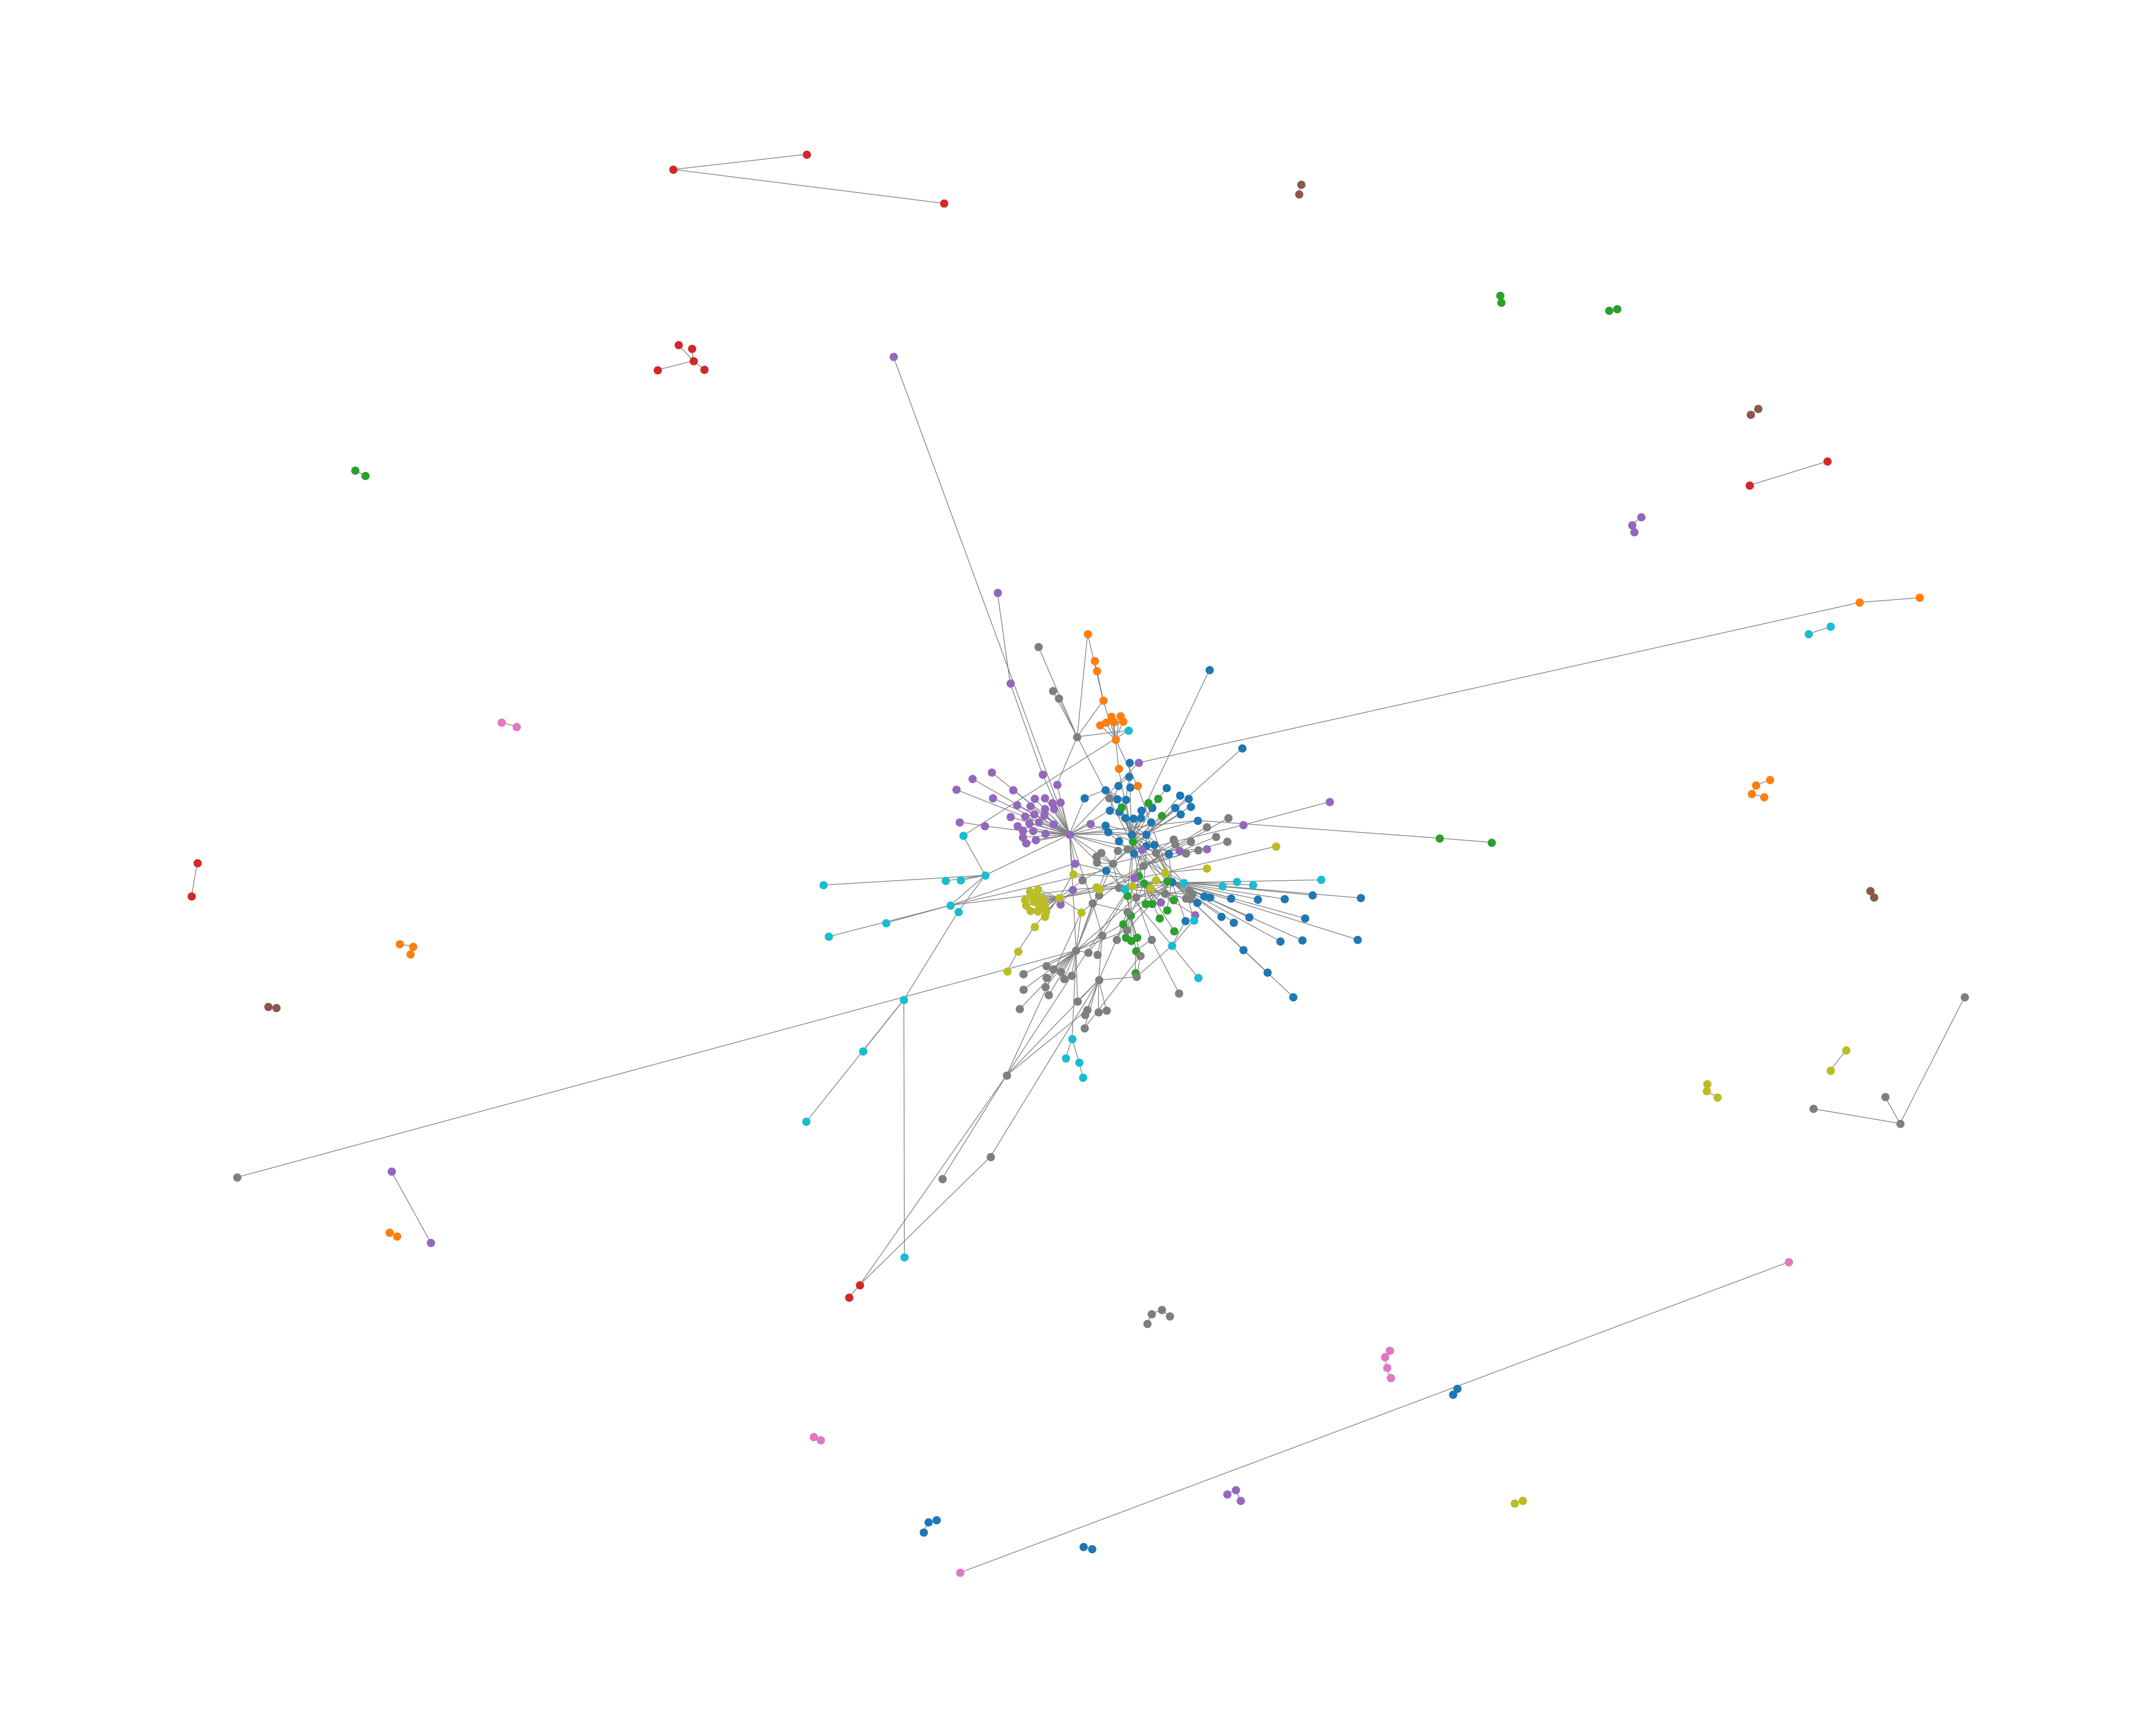

In [274]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain

plt.figure(figsize=(40, 32))
pos = nx.spring_layout(G)

nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray',node_size=100)
for community_idx, community_nodes in enumerate(community):
    nx.draw_networkx_nodes(G, pos, nodelist=community_nodes, node_color=f'C{community_idx}',node_size=100)

plt.savefig('1.png')


In [275]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain
from fa2 import ForceAtlas2


# Create ForceAtlas2 instance
forceatlas2 = ForceAtlas2()

# Apply ForceAtlas2 layout to the graph
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

# Draw the nodes and edges of the graph
nx.draw(G, community, with_labels=False, node_size=10, node_color='blue', edge_color='gray', alpha=0.5)

# Iterate over the communities and draw them with different colors
for community_idx, community_nodes in enumerate(partition):
    nx.draw_networkx_nodes(G, positions, nodelist=community_nodes, node_color=f'C{community_idx}', node_size=10)

# Add legend for communities
plt.legend()

# Display the plot
plt.show()


ModuleNotFoundError: No module named 'fa2'

In [280]:
pos = nx.spring_layout(G)  # Layout algorithm
plt.figure(figsize=(12, 8))  # Set figure size
for i, comm_nodes in enumerate(community):
    nx.draw_networkx_nodes(G, pos, nodelist=comm_nodes, node_size=50, node_color=plt.cm.tab10(i))
nx.draw_networkx_edges(G, pos, alpha=0.5)  # Draw edges
plt.axis('off')  # Turn off axis
plt.show()  # Show plot

ModuleNotFoundError: No module named 'scipy'